In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sn
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community

In [3]:
# Lets create some fake data to test the algorithm on

columns = ['ID', 'colleague_1','colleague_2','colleague_3','connection_1','connection_2','connection_3','productivity_1','productivity_2','productivity_3','positivity_1','positivity_2','positivity_3','consc_1','consc_2','consc_3',
                                       'Openness', 'Conscientiousness','Extraversion','Neuroticism',
                                      'team_productivity','work_satisfaction']
N = 20

data = np.zeros((N,len(columns))) #rewrite so second dimension == length of columns

data = pd.DataFrame(data)


data.columns = columns

# Create our team of 20 bots
data.ID = range(1,N+1)

In [4]:
# Create random connections between teammates. Who are the three teammates you interact with
# the most?
data.colleague_1 = random.choices(list(data.ID), k=N)    
data.colleague_2 = random.choices(list(data.ID), k=N)    
data.colleague_3 = random.choices(list(data.ID), k=N)   

# make sure the three teammates are different for each individual

for i in range(len(data.colleague_1)):
    while (data.colleague_1[i] == data.colleague_2[i]) | (data.colleague_2[i] == data.colleague_3[i]) | (data.colleague_1[i] == data.colleague_3[i]):
        data.colleague_1[i] = random.randint(1,N)
        data.colleague_2[i] = random.randint(1,N)
        data.colleague_3[i] = random.randint(1,N)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [5]:
# Create fake scores for all the survey answers. All questions are likert scale 1-5

for i in range(4,len(columns)):
    
    data.iloc[:,i] = np.random.normal(3,1.5,N)

# How many 0 and 5 values are there? (hepls choose variance)
#zyu = (data.iloc[:,4:20] >= 5)|(data.iloc[:,4:20] <= 1)
#np.sum(zyu)

# Make sure values are between 1 and 5

data[data.iloc[:,4:len(columns)] > 5] = 5

data[data.iloc[:,4:len(columns)] < 1] = 1

# round values to 2 decimal places to reduce mess
data = data.round(2)

In [80]:
# this will be useful as a function

def generate_likert_answers(N):
    answers = np.random.normal(3,1.5,N)
    answers[answers > 5] = 5
    answers[answers < 1] = 1
    answers = [int(ans) for ans in answers]
    
    return answers

In [6]:
# Lets look at our data!

data

#data.describe()

,ID,colleague_1,colleague_2,colleague_3,connection_1,connection_2,connection_3,productivity_1,productivity_2,productivity_3,...,positivity_3,consc_1,consc_2,consc_3,Openness,Conscientiousness,Extraversion,Neuroticism,team_productivity,work_satisfaction
0,1,19,3,5,4.16,5.00,5.00,1.31,2.05,2.37,...,1.91,3.35,5.00,2.19,2.11,5.00,1.00,3.22,4.40,5.00
1,2,15,5,4,2.66,2.48,1.00,5.00,3.29,3.77,...,2.28,5.00,2.75,1.00,2.43,3.14,2.11,3.33,2.21,3.61
2,3,18,13,20,5.00,2.54,1.09,4.60,2.68,3.07,...,2.26,1.72,2.60,3.31,3.72,5.00,2.86,1.22,1.32,4.60
3,4,5,7,6,2.99,3.29,1.63,4.87,1.27,4.20,...,1.18,1.67,2.46,4.70,3.16,4.74,2.02,2.52,1.78,2.29
4,5,11,1,9,3.69,2.80,2.20,1.81,2.81,3.58,...,3.61,2.23,5.00,3.62,3.70,3.67,3.93,1.63,3.37,3.73
5,6,8,1,12,1.49,2.58,3.21,2.58,3.95,2.10,...,2.14,5.00,1.20,1.40,4.75,3.87,2.57,1.00,2.82,2.23
6,7,2,8,16,1.82,2.56,3.64,4.23,2.24,4.69,...,3.17,2.08,3.60,2.27,5.00,2.39,5.00,2.06,2.87,1.00
7,8,19,13,20,2.37,1.14,3.39,1.66,3.07,1.00,...,3.13,1.00,3.01,3.80,5.00,1.00,1.00,3.07,3.02,3.87
8,9,9,16,6,2.35,5.00,3.57,2.96,5.00,1.75,...,5.00,1.52,1.49,1.20,1.70,3.15,3.41,1.05,2.89,2.98
9,10,13,18,7,1.48,1.70,1.43,2.01,3.63,3.13,...,4.32,2.90,2.91,2.26,5.00,2.01,4.72,2.10,4.06,3.50


Ok, now lets analyse this!

In [7]:
# Popularity ranking compared with productivity ranking

# Who are the most popular people?

#ranking = data.loc[:,['colleague_1','colleague_2','colleague_3']]

# Count mentions by colleagues
ranking_1 = pd.DataFrame(data.colleague_1.value_counts())
ranking_2 = pd.DataFrame(data.colleague_2.value_counts())
ranking_3 = pd.DataFrame(data.colleague_3.value_counts())

ranking_1['ID'] = ranking_1.index
ranking_2['ID'] = ranking_2.index
ranking_3['ID'] = ranking_3.index

ranking_1.rename(columns={'colleague_1' : 'ranking_1'},inplace =True)
ranking_2.rename(columns={'colleague_2' : 'ranking_2'},inplace =True)
ranking_3.rename(columns={'colleague_3' : 'ranking_3'},inplace =True)

ranking = np.zeros((N,1))
ranking = pd.DataFrame(ranking)
ranking.columns = ['ID'] #,'ranking_1','ranking_2','ranking_3','ranking_sum']
ranking.ID = range(1,N+1)

# create a popularity rating

ranking = ranking.merge(ranking_1,on='ID',how='outer')
ranking = ranking.merge(ranking_2,on='ID',how='outer')
ranking = ranking.merge(ranking_3,on='ID',how='outer')

# 0 for no mentions 
ranking.fillna(0,inplace=True)

# summary rating
ranking['ranking_sum'] = ranking.ranking_1 + ranking.ranking_2 + ranking.ranking_3

data = data.merge(ranking,on='ID',how='outer')

# Who are the most popular people? 
# For me its number 4! What is it for you?
# (will be different every time cause no random seed)

key_teammates = ranking.sort_values(by='ranking_sum',ascending=False).head(5)
key_teammates

,ID,ranking_1,ranking_2,ranking_3,ranking_sum
8,9,4.0,0.0,1.0,5.0
15,16,1.0,2.0,2.0,5.0
12,13,2.0,2.0,1.0,5.0
7,8,3.0,2.0,0.0,5.0
16,17,1.0,3.0,0.0,4.0


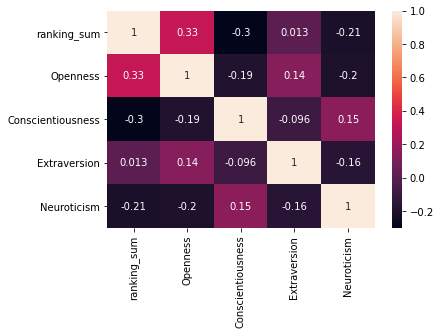

In [8]:
# Is the popularity of the individual related to their personality and peer evaluations?

experiment_1 = data.loc[:,['ranking_sum', 'Openness', 'Conscientiousness','Extraversion','Neuroticism']]

corr = experiment_1.corr()

sn.heatmap(corr, annot=True)

plt.show()



In [8]:
# Get personality characteristics of your top connections based on their self-report

data['colleague_1_C'] = np.zeros(N)
data['colleague_2_C'] = np.zeros(N)
data['colleague_3_C'] = np.zeros(N)
data['colleague_1_N'] = np.zeros(N)
data['colleague_2_N'] = np.zeros(N)
data['colleague_3_N'] = np.zeros(N)

for i in data.ID.index:
    
    # Get the Conscientiousness level of your colleagues based on self-report
    data.colleague_1_C[i] = data.Conscientiousness[data.ID == data.colleague_1[i]]
    data.colleague_2_C[i] = data.Neuroticism[data.ID == data.colleague_2[i]]
    data.colleague_3_C[i] = data.Neuroticism[data.ID == data.colleague_3[i]]

    # Get the Neuroticism level of your colleagues based on self-report
    data.colleague_1_N[i] = data.Neuroticism[data.ID == data.colleague_1[i]]
    data.colleague_2_N[i] = data.Neuroticism[data.ID == data.colleague_2[i]]
    data.colleague_3_N[i] = data.Neuroticism[data.ID == data.colleague_3[i]]
    
# Here we should also calculate average personality of top interactions.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_l

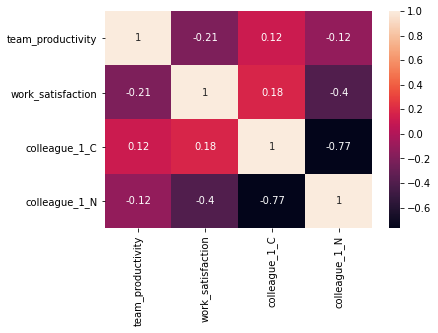

In [9]:
#Does team productivity relate to the personality and intelligence of the connections?

experiment_2 = data.loc[:,['team_productivity','work_satisfaction','colleague_1_C','colleague_1_N']]

corr = experiment_2.corr()

sn.heatmap(corr, annot=True)

plt.show()

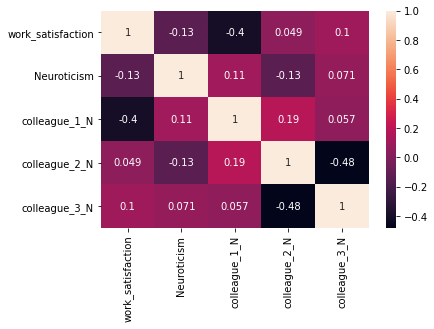

In [10]:
# Is work satsifaction related to personal level of neuroticism or that of teammates?

experiment_3 = data.loc[:,['work_satisfaction','Neuroticism','colleague_1_N','colleague_2_N','colleague_3_N']]

corr = experiment_3.corr()

sn.heatmap(corr, annot=True)

plt.show()

In [11]:
# Does self-report of personality match up with peer report? 
# E.g. are conscientious people on time for their job?

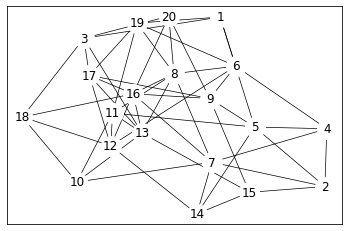

In [9]:
# What are the real teams? Identify clusters of connections. 


# Lets assume symmetry and build a symmetrical graph. Can use assymetrical graphs to identify
# unequal relationships

team_graph = nx.Graph()

for i in data.ID.index:
    team_graph.add_edge(str(data.ID[i]),str(data.colleague_1[i]))
    team_graph.add_edge(str(data.ID[i]),str(data.colleague_2[i]))
    team_graph.add_edge(str(data.ID[i]),str(data.colleague_3[i]))
    
options = {
'node_color': 'white',
'node_size': 400,
'width': 0.7,
}
    
nx.draw_networkx(team_graph, **options)


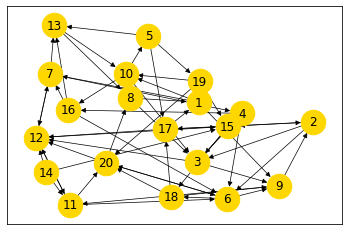

In [13]:
# What about an assymetrical graph?

team_graph = nx.DiGraph()

for i in data.ID.index:
    team_graph.add_edge(str(data.ID[i]),str(data.colleague_1[i]))
    team_graph.add_edge(str(data.ID[i]),str(data.colleague_2[i]))
    team_graph.add_edge(str(data.ID[i]),str(data.colleague_3[i]))

options = {
'node_color': 'gold',
'node_size': 600,
'width': 0.7,
}

nx.spring_layout(team_graph)
nx.draw_networkx(team_graph, **options)

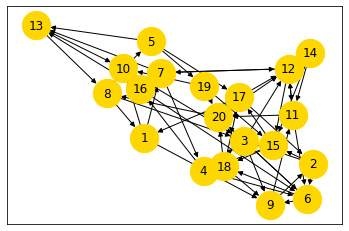

In [14]:
# Lets add connection weights to the graph. How much do people interact?

team_graph = nx.DiGraph()

for i in data.ID.index:
    team_graph.add_edge(str(data.ID[i]),str(data.colleague_1[i]), weight = data.connection_1[i])
    team_graph.add_edge(str(data.ID[i]),str(data.colleague_2[i]), weight = data.connection_1[i])
    team_graph.add_edge(str(data.ID[i]),str(data.colleague_3[i]), weight = data.connection_2[i])

    
options = {
'node_color': 'gold',
'node_size': 800,
'width': 1,
}

nx.spring_layout(team_graph)
nx.draw_networkx(team_graph,**options)


In [15]:
# We can create a multigraph to specify different relationships 

G = nx.MultiGraph()
G.add_edge('A','B',relation ='neighbor')
G.add_edge('A','B',relation='friend)
G.add_edge('B','C', relation='neighbor')
G.add_edge('D','C',relation='friend')

SyntaxError: EOL while scanning string literal (<ipython-input-15-5a564f57d817>, line 5)

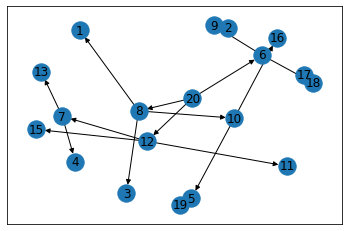

In [16]:
# How many connections does someone specific in a graph have?

nx.degree(team_graph,'10')

# How clustered is the graph around someone? 
# clustering = what proportion of the nodes connections are also connected to each other?

nx.clustering(team_graph,'10')

# What is the average clustering coefficient? 
# sum of all the local clustering coefficients divided by the number of nodes

nx.average_clustering(team_graph)

# what is the shortest path between two people through the network? 
nx.shortest_path(team_graph, '16', '10')

# how long is that path?
nx.shortest_path_length(team_graph, '16', '10')

# finding distance to other nodes from one persons perspective

T = nx.bfs_tree(team_graph, '20')
nx.draw_networkx(T)


In [134]:
# Identifying the biggest influencers

# measure of connections
nx.degree_centrality(team_graph)

# measure of connections to highly connected people
#nx.eigenvector_centrality(team_graph)

# measure of nodes who lie on the shortest path between many nodes
# these people are at key "traffic" junctions and may control flow of information
#nx.betweenness_centrality(team_graph)

{'1': 1.2105263157894737,
 '3': 1.4736842105263157,
 '2': 1.7368421052631577,
 '7': 1.263157894736842,
 '5': 1.3157894736842104,
 '9': 0.894736842105263,
 '14': 1.6842105263157894,
 '4': 1.0526315789473684,
 '11': 1.1052631578947367,
 '19': 0.894736842105263,
 '6': 1.1052631578947367,
 '15': 0.9473684210526315,
 '10': 0.894736842105263,
 '20': 0.894736842105263,
 '8': 0.7894736842105263,
 '17': 1.263157894736842,
 '12': 1.2105263157894737,
 '18': 1.0526315789473684,
 '13': 0.894736842105263,
 '16': 1.263157894736842}

In [18]:
# Identifying real "teams" in data

#communities = community.greedy_modularity_communities(team_graph)
#import community as community_louvain
#abc = community_louvain.generate_dendrogram(team_graph)
#abc = community_louvain.best_partition(team_graph)

from networkx.algorithms import community

communities_generator = community.girvan_newman(team_graph)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))


[['1', '10', '3', '8'],
 ['11', '12', '14', '15', '17', '18', '19', '2', '20', '5', '6', '9'],
 ['13', '16', '4', '7']]

In [57]:
# Does team diversity (cognitive or demographic) affect team performance, satisfaction?

teams = next_level_communities

team1 = pd.DataFrame(teams[1])

team1.columns = ['ID']

team1['team1_satisfaction'] = np.zeros((len(team1),1))

for i in range(1,len(team1)):
    team1.team1_satisfaction[i] = data.work_satisfaction[data.ID == i]

# Create a diveristy index for team1
team1['team1_openness'] = np.zeros((len(team1),1))
team1['team1_neuroticism'] = np.zeros((len(team1),1))
team1['team1_extraversion'] = np.zeros((len(team1),1))

for i in range(1,len(team1)):
    team1.team1_openness[i] = data.Openness[data.ID == i]
    team1.team1_neuroticism[i] = data.Neuroticism[data.ID == i]
    team1.team1_extraversion[i] = data.Extraversion[data.ID == i]
    
def calculate_diversity(trait):
    individual_diversity = np.zeros((len(trait),1))
    for i in range(0,len(trait)):
        difference = abs(trait[i] - trait)
        individual_diversity[i] = np.mean(difference)
    
    #average_diversity = np.mean(individual_diversity)
    return individual_diversity

team1['openness_div'] = calculate_diversity(team1.team1_openness)
team1['neuroticism_div'] = calculate_diversity(team1.team1_neuroticism)
team1['extraversion_div'] = calculate_diversity(team1.team1_extraversion)

team1_diversity_index = [np.mean(team1.openness_div),np.mean(team1.neuroticism_div),np.mean(team1.extraversion_div)]
team1_diversity_index = np.mean(team1_diversity_index)


# What is the determinant of how the team is formed? Is it personality, demographic characteristics,diversity

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A va

In [ ]:
# Does pattern of connections affect team performance? 

In [58]:
team1_diversity_index

2.1495833333333336

In [ ]:
range(1,len(teams[1])

In [ ]:
# Does being connected with a particular colleague improve or reduce performance? 

In [ ]:
# Does being connected to a key node improve your performance? does it lead to more connections?

In [ ]:
# 
data.columns

Lets create a different set of data and graphs for Slava's suggestion. Three stages:

1. Social graph

Create frame with ID, name, list of friends

Get frequency of interaction 

Get intensity of interaction??

N x N_friends x list of characteristics

2. Circles of trust

For a variety of situations, rank colleagues 0 (do not want to cooperate) to 3 (want to cooperate)

3. Teams 

Who are the people that make it onto the team?

Who are the people that make it onto 50% of the team?

What about the last person standing? 



In [105]:
# create main data table 

columns = ['participant_ID','Name','Age','Gender','Experience','Department/function','Role',
                'connection_rating','interaction_rating','social_rating','agg_trust_rating_sum',
                'agg_trust_rating_conflict','agg_trust_rating_problem','agg_trust_rating_idea',
                'agg_review_CONSC','agg_review_CRIT','agg_review_prod','Reflector','Constructor',
                'Centrist','Extraversion','Neuroticism','Conscientiousness','Agreeableness',
                'team_productivity','work_satisfaction']

# number of participants

N = 20

# main dataset
data = np.zeros((N,len(columns))) 

data = pd.DataFrame(data)

data.columns = columns

# Create our team of 20 bots
data.participant_ID = range(1,N+1)

# create likert scores

temp = ['Reflector','Constructor',
                'Centrist','Extraversion','Neuroticism','Conscientiousness','Agreeableness',
                'team_productivity','work_satisfaction']

for col in temp:
    data[col] = generate_likert_answers(N)


In [106]:
# create individual peer review files

peer_review_columns = ['colleague_ID','colleague_name','interaction_strength',
                         'trust_rating_sum','trust_rating_conflict','trust_rating_problem',
                         'trust_rating_idea','review_CONSC','review_CRIT','review_prod',
                         'dream_team','org_relationship']

#all_peer_reviews = np.zeros((1,N))

#all_peer_reviews = pd.DataFrame(all_peer_reviews)

all_peer_reviews = []


for i in range(0,N):
    
    # how many connections does this person have? 
    n_connections = int(np.random.normal(10,5,1))
    
    if (n_connections > 20):
        n_connections = 20
    elif (n_connections < 0):
        n_connections = 0
        
    # create individual peer review table
    peer_review = np.zeros((n_connections,len(peer_review_columns)))
    peer_review = pd.DataFrame(peer_review)
    peer_review.columns = peer_review_columns
    
    # create random IDs 
    selected_peers = random.sample(list(data.participant_ID),n_connections)
    
    peer_review.colleague_ID = selected_peers
    
    # fill out likert columns
    for col in peer_review_columns[2:-2]:
        peer_review[col] = generate_likert_answers(n_connections)
        
    all_peer_reviews.append(peer_review)

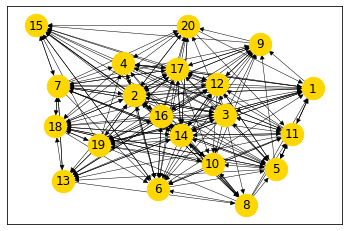

In [112]:
# Lets create a directed graph with weights!

team_graph = nx.DiGraph()

for i in range(0,len(all_peer_reviews)):
    
    temp = all_peer_reviews[i]
    
    participant_ID = str(i+1)
    
    for con in temp.colleague_ID.index:
        team_graph.add_edge(participant_ID,str(temp.colleague_ID[con]), weight = temp.interaction_strength[con])
  
options = {
'node_color': 'gold',
'node_size': 500,
'width': 0.5,
}

nx.spring_layout(team_graph)
nx.draw_networkx(team_graph,**options)

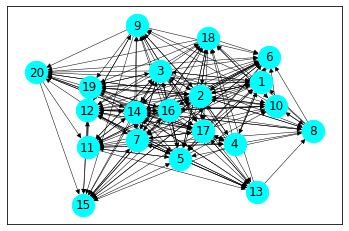

In [120]:
# Now lets create a trust graph for conflict resolution

team_graph = nx.DiGraph()

for i in range(0,len(all_peer_reviews)):
    
    temp = all_peer_reviews[i]
    
    participant_ID = str(i+1)
    
    for con in temp.colleague_ID.index:
        team_graph.add_edge(participant_ID,str(temp.colleague_ID[con]), weight = temp.trust_rating_conflict[con])
  
options = {
'node_color': 'aqua',
'node_size': 500,
'width': 0.5,
}

nx.spring_layout(team_graph)
nx.draw_networkx(team_graph,**options)

In [140]:
# How many connections does everyone have?

clustering_coefficient = []

for i in range(0,N):
    
    person = str(data.participant_ID[i])
    
    # the nx.degree function includes connections from the person
    
    # subtract them to only include connection to that person
    
    data.connection_rating[i] = nx.degree(team_graph,person) - len(all_peer_reviews[i])

    
    # How clustered is the graph around someone? 
    # clustering = what proportion of the nodes connections are also connected to each other?
    clustering_coefficient.append(nx.clustering(team_graph,person))

data['clustering_coefficient'] = clustering_coefficient


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [141]:
# Top connections 

data.sort_values(by='connection_rating',ascending=False)

,participant_ID,Name,Age,Gender,Experience,Department/function,Role,connection_rating,interaction_rating,social_rating,...,Reflector,Constructor,Centrist,Extraversion,Neuroticism,Conscientiousness,Agreeableness,team_productivity,work_satisfaction,clustering_coefficient
1,2,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,...,1,2,5,1,1,2,3,2,2,0.507743
4,5,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,...,1,5,4,3,4,2,1,3,2,0.552632
5,6,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,...,3,4,2,3,1,1,4,2,3,0.555825
0,1,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,...,2,1,4,5,2,1,3,3,2,0.607843
14,15,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,...,5,3,1,5,3,4,2,1,1,0.594017
13,14,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,...,2,4,4,5,1,4,1,1,4,0.524764
17,18,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,1,1,2,1,2,1,5,1,3,0.594595
16,17,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,1,3,3,3,4,2,3,2,2,0.572491
11,12,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,4,1,3,1,3,3,3,3,2,0.566802
10,11,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,1,1,2,5,5,2,1,3,1,0.539157


In [139]:
len(all_peer_reviews[3])

11